# Model Prep

In [125]:
# Dependencies
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import math

In [126]:
# Location files
features_loc = "../dataset/train_feat.pickle"
target_loc = "../dataset/train_target.pickle"

In [127]:
features_df = pd.read_pickle("../dataset/train_feat.pickle")
target_df = pd.read_pickle("../dataset/train_target.pickle")

## Check for missing values

In [128]:
# Check NA in target df
target_df.isna().sum()
#Only one in PERMA and HAP, look at the row
with pd.option_context('display.max_columns', None):
    display(target_df[target_df["PERMA"].isna()])

,id,gender,born,education,employed,income,A_2,N_1,P_1,E_1,A_1,H_1,M_1,R_1,M_2,E_2,LON,H_2,P_2,N_2,A_3,N_3,E_3,H_3,R_2,M_3,R_3,P_3,HAP,participate,insta_user_id,completed,start_q,end_q,network_id,P,E,R,M,A,PERMA,N_EMO,P_EMO,imagecount,private_account
4,0a1002b2232a4ecbde604462f6d84bf9,Female,1993,College graduate,A student,"$20,000 to $29,999",7,5,7,4,6,7,7,7,6,7,5,6,2,2,8,2,7,6,6,7,5,8,NaN,Yes,263042348,true,2016-12-05 14:02:36,2016-12-05 14:04:43,aae4bbb89a,5.666667,6.0,6.0,6.666667,7.0,NaN,3.0,5.666667,73.0,public


In [129]:
# Impute hapiness by median of all values 
target_df.loc[target_df["PERMA"].isna(),"HAP"]  = target_df["HAP"].median()

In [130]:
# Create vector for columns of questions
questions = list(target_df.columns[6:29])
questions.remove('LON')
questions = [q for q in questions if q not in ('LON', 'N_1', 'N_2', 'N_3','H_1', 'H_2', 'H_3')]
questions.sort()
print(questions)

['A_1', 'A_2', 'A_3', 'E_1', 'E_2', 'E_3', 'HAP', 'M_1', 'M_2', 'M_3', 'P_1', 'P_2', 'P_3', 'R_1', 'R_2', 'R_3']


In [131]:
# Calculate PERMA score using mean of all questions
target_df.loc[target_df["PERMA"].isna(),"PERMA"] =  target_df.loc[target_df["PERMA"].isna(),
                                                                  questions].mean(axis = 1)
# Check if all individual questions aa up to the PERMA score
(target_df[questions].mean(axis = 1) == target_df["PERMA"]).mean()

1.0

In [8]:
# Check missing values of features
features_df.isnull().sum()

image_height                   0
image_width                    0
data_memorability              0
user_followed_by               0
user_follows                   0
user_posted_photos             0
age                           11
glasses                       11
face_emotion_ANGRY            11
face_emotion_CALM             11
face_emotion_CONFUSED         11
face_emotion_DISGUSTED        11
face_emotion_HAPPY            11
face_emotion_SAD              11
face_emotion_SURPRISED        11
facial_hear                   11
smile                         11
unkown_gender                 11
male                          11
female                        11
anp_sentiment                  0
emotion_score                  0
emotion_label_acceptance       0
emotion_label_admiration       0
emotion_label_amazement        0
emotion_label_anger            0
emotion_label_annoyance        0
emotion_label_anticipation     0
emotion_label_apprehension     0
emotion_label_boredom          0
emotion_la

In [9]:
# 11 people did not have any faces in their data. All values will be imputed to 0
features_df = features_df.fillna(0)
features_df.isnull().sum().sum()

0

## Check Histograms

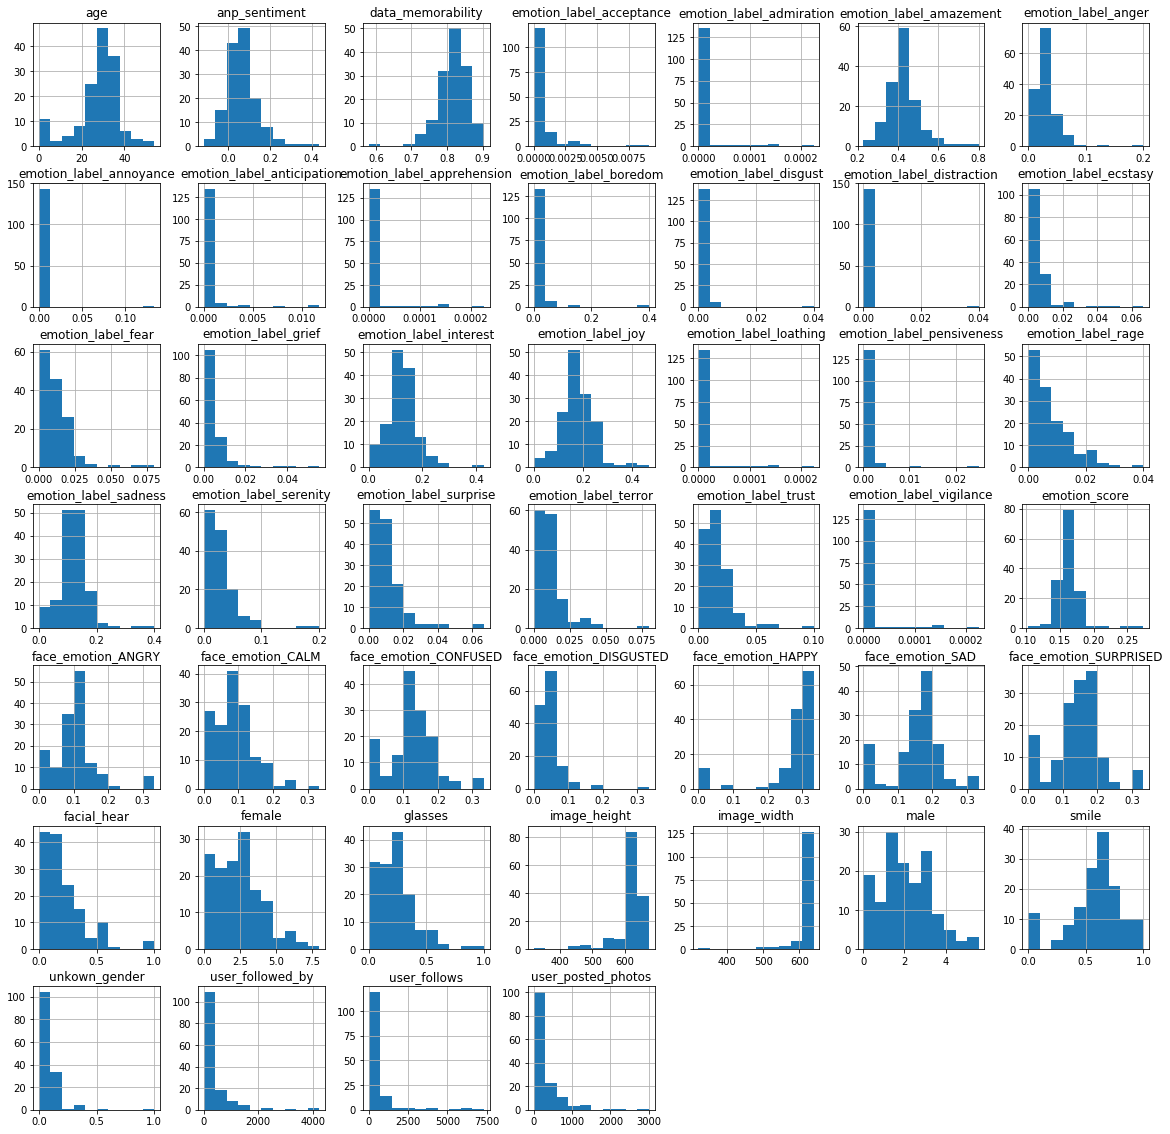

In [10]:
features_df.hist(figsize= (20,20))
plt.show()

In [11]:
# Select all values not equal to 0 to perform log transform
values_to_transform = ["user_followed_by" , "user_follows","user_posted_photos"]
for value in values_to_transform:
    select_log_transform = (features_df.loc[:,[value]] != 0)[value]
    features_df.loc[select_log_transform,[value]] = np.log10(features_df.loc[select_log_transform,[value]])

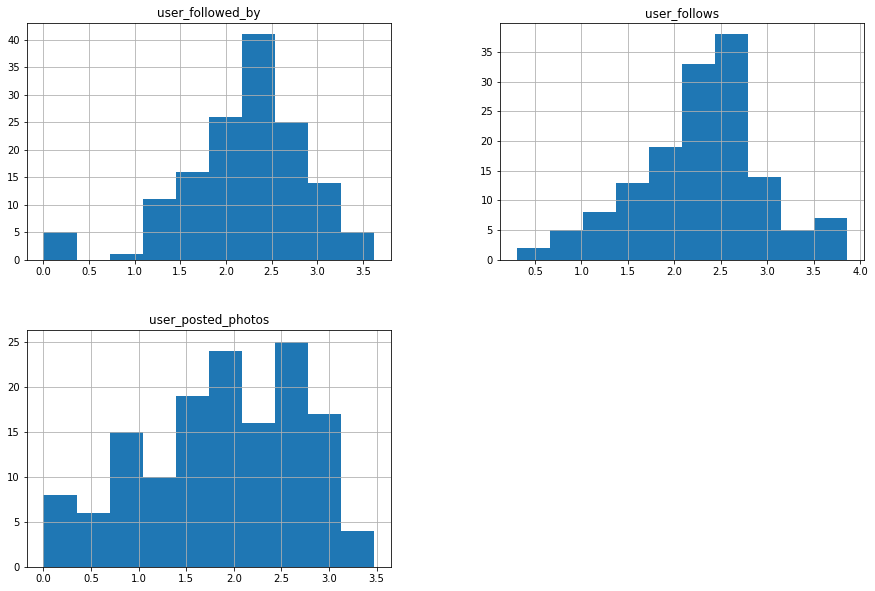

In [12]:
features_df.loc[:,values_to_transform].hist(figsize= (15,10))
plt.show()

## Check correlation of features

In [13]:
corrMatrix = features_df.corr()
corrMatrix.style.applymap(lambda x: 'color:green' if x > 0.65 else 'color:red')

In [16]:
corrMatrixspear = features_df.corr(method="spearman")
corrMatrixspear.style.applymap(lambda x: 'color:green' if x > 0.65 else 'color:red')

In [34]:
# Select combinations of correlated pairs and drop the one that is least correlated with target_df["PERMA"]  
pd.merge(target_df, features_df, on=[target_df.index])[['PERMA', 'image_height', 'image_width', 'user_followed_by', 'user_follows', 'smile', 'face_emotion_HAPPY']].corr().style.applymap(lambda x: 'color:green' if x > 0.6 else 'color:red')

,PERMA,image_height,image_width,user_followed_by,user_follows,smile,face_emotion_HAPPY
PERMA,1,-0.0692025,-0.054069,-0.0592727,-0.0201063,-0.00396571,-0.133948
image_height,-0.0692025,1,0.803878,0.242942,0.144628,0.26348,0.345436
image_width,-0.054069,0.803878,1,0.277877,0.237941,0.295181,0.386131
user_followed_by,-0.0592727,0.242942,0.277877,1,0.772174,0.00411803,0.242623
user_follows,-0.0201063,0.144628,0.237941,0.772174,1,0.0223842,0.173322
smile,-0.00396571,0.26348,0.295181,0.00411803,0.0223842,1,0.833323
face_emotion_HAPPY,-0.133948,0.345436,0.386131,0.242623,0.173322,0.833323,1


In [36]:
# we need to drop the lowest correlated combinations of variables
# these are:
# 1. image_height
# 2. user_followed_by
# 3. face_emotion_HAPPY
features_df_cleaned = features_df.copy().drop(["image_height", "user_followed_by", "face_emotion_HAPPY"], axis=1)
features_df_cleaned

,image_width,data_memorability,user_follows,user_posted_photos,age,glasses,face_emotion_ANGRY,face_emotion_CALM,face_emotion_CONFUSED,face_emotion_DISGUSTED,...,emotion_label_joy,emotion_label_loathing,emotion_label_pensiveness,emotion_label_rage,emotion_label_sadness,emotion_label_serenity,emotion_label_surprise,emotion_label_terror,emotion_label_trust,emotion_label_vigilance
148,636.123711,0.780543,2.120574,1.986772,26.560606,0.303030,0.161616,0.030303,0.101010,0.060606,...,0.098625,0.000000,0.002062,0.004124,0.139519,0.082474,0.010309,0.005842,0.014433,0.000000
98,612.000000,0.738017,1.000000,1.414973,39.062500,0.500000,0.041667,0.000000,0.125000,0.166667,...,0.129487,0.000000,0.000000,0.000000,0.164103,0.029487,0.015385,0.007692,0.015385,0.000000
16,640.000000,0.730110,1.892095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000
75,627.835269,0.818744,3.035830,2.976350,30.415625,0.212289,0.099148,0.081829,0.122735,0.064491,...,0.181392,0.000038,0.000671,0.012005,0.137394,0.020146,0.011970,0.012428,0.019256,0.000038
18,639.962914,0.821806,2.720986,2.891537,35.418737,0.335749,0.100414,0.055210,0.087302,0.069933,...,0.243400,0.000000,0.000000,0.001854,0.088124,0.022208,0.015541,0.003400,0.012671,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,626.335025,0.778228,2.127105,2.296665,29.700293,0.428756,0.088628,0.074517,0.147757,0.031064,...,0.124365,0.000000,0.000000,0.006091,0.138409,0.027411,0.012183,0.008122,0.014213,0.000000
106,631.831640,0.825757,3.712144,2.839478,33.364339,0.259421,0.071602,0.099928,0.140500,0.030924,...,0.171940,0.000000,0.000000,0.007837,0.106863,0.047218,0.017188,0.011176,0.021335,0.000000
14,638.564103,0.809243,2.571709,2.193125,35.276855,0.174408,0.116477,0.113180,0.133050,0.079821,...,0.211828,0.000000,0.001075,0.006452,0.129892,0.019355,0.006452,0.018925,0.012903,0.000000
92,597.333333,0.768907,2.053078,1.176091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.146667,0.000000,0.000000,0.000000,0.133333,0.093333,0.000000,0.013333,0.040000,0.000000


In [38]:
# Save cleaned data
features_df_cleaned.to_pickle('../dataset/train_feat_cleaned.pickle')
target_df.to_pickle('../dataset/train_target_cleaned.pickle')